# Import Preprocessed Data

In [ ]:
#PROJECT_ROOT = "/content/drive/My Drive/CMPT419/Project" #@param ["/content/drive/My Drive/CMPT419/Project", "/content/drive/My Drive/school-419-project"] {allow-input: true}

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive/')
#%cd {PROJECT_ROOT}

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/
/content/drive/My Drive/CMPT419/Project


In [1]:
# Import Openface's data
import pandas as pd
import os
savename = "aggregated_openface_data.pickle"

openface_csvs = "./openface_processed/multi"

df = pd.DataFrame()

if os.path.isfile(savename):
  print("Loading combined CSV's from file")
  df = pd.read_pickle(savename)
else:
  for root, dirs, files in os.walk(openface_csvs):
    dirs.clear()  # don't recurse

    for f in [f for f in files if f[-4:] == '.csv']:
      tempdata = pd.read_csv(os.path.join(root, f), skipinitialspace=True)
      tempdata["filename"] = f[0:-4].strip()  # make column with sample number (remove .csv suffix, whitespace)
      df = pd.concat([df, tempdata])

  print("Saving combined CSV's to file")
  df.to_pickle(savename)
df.describe()

Loading combined CSV's from file


,frame,face_id,timestamp,confidence,success,gaze_0_x,gaze_0_y,gaze_0_z,gaze_1_x,gaze_1_y,...,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c
count,22935.000000,22935.000000,22935.000000,22935.000000,22935.000000,22935.000000,22935.000000,22935.000000,22935.000000,22935.000000,...,22935.000000,22935.000000,22935.000000,22935.000000,22935.000000,22935.000000,22935.000000,22935.000000,22935.000000,22935.000000
mean,155.616133,0.501809,4.605910,0.751813,0.766122,0.036090,0.203211,-0.663631,-0.076915,0.208771,...,0.294790,0.399913,0.581600,0.286767,0.381905,0.208197,0.404229,0.323261,0.406584,0.318552
std,164.296348,0.710695,4.882572,0.367902,0.423305,0.332307,0.171565,0.378508,0.330183,0.175701,...,0.455958,0.489891,0.493307,0.452262,0.485864,0.406027,0.490753,0.467732,0.491207,0.465925
min,1.000000,0.000000,0.000000,0.000000,0.000000,-0.805486,-0.448546,-0.999994,-0.914196,-0.414886,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,46.000000,0.000000,1.600000,0.770000,1.000000,-0.196749,0.000000,-0.932839,-0.361876,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,97.000000,0.000000,3.365000,0.980000,1.000000,0.000000,0.210941,-0.857065,0.000000,0.219472,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,188.000000,1.000000,5.772000,0.980000,1.000000,0.286586,0.324906,-0.578735,0.125412,0.340716,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,837.000000,3.000000,34.868000,0.980000,1.000000,0.931122,0.726961,0.000000,0.893593,0.843826,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [2]:
# filter out datas with success = 1 or confidence < 0.95
df = df[(df['confidence'] >=0.65) & (df['success'] == 1)]
df.reset_index(drop=True, inplace=True)
# print(df.filename.unique())
# print(len(df.keys()))

In [3]:
# Import audio data
audio_df = pd.read_csv("audio-features.csv").drop("Unnamed: 0", axis=1)
audio_df.head()

,mean_pitch,min_pitch,max_pitch,mean_intensity,root_mean_square,center_of_gravity,kurtosis,skewness,standard_deviation,mean_f1_frequency,mean_f2_frequency,mean_speech_rate,number_of_silent_intervals,filename,estimated_frame_number
0,290.447878,223.029898,420.621402,83.265478,0.291275,629.042192,60.851689,4.878547,475.672620,605.231710,1634.643303,0.49362,2,nonflirt-PJP-C7TCaM8-6,0
1,288.354722,223.129737,420.629276,83.295576,0.292287,630.297852,60.325458,4.840207,476.914570,626.793360,1624.179187,0.49362,2,nonflirt-PJP-C7TCaM8-6,1
2,286.543449,223.243593,420.609286,83.482699,0.298652,662.504028,68.563877,4.773974,496.830745,636.716477,1611.940717,0.49362,2,nonflirt-PJP-C7TCaM8-6,2
3,284.431711,223.167087,420.564528,83.700942,0.306251,683.002668,58.698875,4.373654,499.577060,648.038718,1610.828022,0.49362,2,nonflirt-PJP-C7TCaM8-6,3
4,282.287917,223.092497,420.501990,83.765693,0.308542,681.849847,49.727052,4.123383,495.618783,657.417870,1599.743717,0.49362,2,nonflirt-PJP-C7TCaM8-6,4


In [4]:
# Check datas consistency
clips_name = df.filename.unique()
audios_name = audio_df.filename.unique()
df = df[df['filename'] != 'nonflirt-ImEnWAVRLU0-2']
df = df[df['filename'] != 'nonflirt-v2VgA_MCNDg-4']

# if len(clips_name) != len(audios_name):
#   missing_video = set(audios_name)-set(clips_name)
#   print(missing_video)
missing_audio = set(df.filename.unique())-set(audio_df.filename.unique())
print(missing_audio)
  # df = df[df['filename'] != missing_video.pop()]
  # audio_df = audio_df[audio_df['filename'] != missing_audio]

print(len(df.filename.unique()))
print(len(audio_df.filename.unique()))


set()
103
103


# Feature Selection

In [5]:
print(df.keys())
# feature_columns = []
# features = train.drop('filename',axis=1).keys()

Index(['frame', 'face_id', 'timestamp', 'confidence', 'success', 'gaze_0_x',
       'gaze_0_y', 'gaze_0_z', 'gaze_1_x', 'gaze_1_y',
       ...
       'AU14_c', 'AU15_c', 'AU17_c', 'AU20_c', 'AU23_c', 'AU25_c', 'AU26_c',
       'AU28_c', 'AU45_c', 'filename'],
      dtype='object', length=335)


# Compute DTW

In [ ]:
# required packages
!pip install fastdtw
import numpy as np
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from tqdm import tqdm, trange

In [ ]:
clips = pd.concat([df.loc[:,"filename"], df.loc[:,"frame":"gaze_angle_y"], df.loc[:,"pose_Tx":"pose_Rz"], df.loc[:,"AU01_r":"AU45_c"]],
                  axis=1)

In [ ]:
def independent_dtw(clip1, clip2, features):
  overall_score = 0
  clip1 = clip1[~clip1.isin([np.nan, np.inf, -np.inf]).any(1)]
  clip2 = clip2[~clip2.isin([np.nan, np.inf, -np.inf]).any(1)]
  for feature in features:
    if feature != 'filename' and feature != 'frame':
      # print(clip1[feature], clip2[feature])
      distance, path = fastdtw(clip1[feature], clip2[feature], dist=euclidean)
      # print(path)
      overall_score+=distance
  return overall_score

# test
clip1 = clips[clips['filename'] == 'nonflirt-PJP-C7TCaM8-6']
clip2 = clips[clips['filename'] == 'flirt-qkq9k5FewvI-1']
test_dtw1 = independent_dtw(clip1, clip2, clips.columns)
clip1 = audio_df[audio_df['filename'] == 'nonflirt-PJP-C7TCaM8-6']
clip2 = audio_df[audio_df['filename'] == 'flirt-qkq9k5FewvI-1']
test_dtw2 = independent_dtw(clip1, clip2, audio_df.columns)

print(test_dtw1+test_dtw2)

273785.2142364928


In [ ]:
import numpy as np
from scipy.spatial.distance import euclidean

from fastdtw import fastdtw

x = np.array([[1,1], [2,2], [3,3], [4,4], [5,5]])
y = np.array([[2,2], [3,3], [4,4]])
distance, path = fastdtw(x, y, dist=euclidean)
print(distance)


2.8284271247461903


In [ ]:
# This would be the final matrix that gives how similar between
# each two clips
def produce_Similarity_Matrix(df, audio_df): # for multimodal
  # This data is missing from OpenFace
  clips_name = df.filename.unique()
  audios_name = audio_df.filename.unique()
  length = len(clips_name)
  features_face = clips.columns
  features_audio = audio_df.columns


  Similarity_Matrix = np.zeros((length,length))
  for col in trange(length, leave=False, position=0):
    for row in trange(length, leave=False, position=0):
      # create a Similarity_Matrix, ie         clip1 clip2 clip3
      #                                 clip1    0    ...   ...
      #                                 clip2   ...    0    ...
      #                                 clip3   ...   ...    0
      clip_name1 = clips_name[col]
      clip1 = clips[clips['filename'] == clip_name1]
      clip_name2 = clips_name[row]
      clip2 = clips[clips['filename'] == clip_name2]
      overall_score1 = independent_dtw(clip1, clip2, features_face)

      clip1 = audio_df[audio_df['filename'] == clip_name1]
      clip2 = audio_df[audio_df['filename'] == clip_name2]
      overall_score2 = independent_dtw(clip1, clip2, features_audio)

      Similarity_Matrix[col][row] = overall_score1+overall_score2
  return Similarity_Matrix

In [ ]:
Similarity_Matrix = produce_Similarity_Matrix(df, audio_df)
sm = Similarity_Matrix
print(sm)

 84%|████████▍ | 87/103 [05:52<01:29,  5.58s/it]

In [ ]:
# Save the result
import pickle
with open('Similarity_Matrix', 'wb') as f:
    pickle.dump(Similarity_Matrix, f)

In [ ]:
# Load the result
import pickle
with open("Similarity_Matrix", "rb") as f:
  Similarity_Matrix = pickle.load(f)

# K-Means Clustering

In [ ]:
# import packages
# !pip install tslearn
from tslearn.clustering import TimeSeriesKMeans
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## look for optimal k to see how many types of flirtatiou/non-flirtatiou is detected

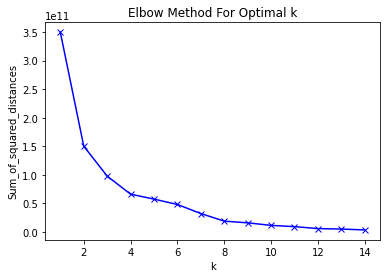

[0 0 0 2 0 2 0 1 0 0 2 2 2 2 0 1 1 2 2 2]


In [ ]:
# We can see that the elbow is around 3 which is the optimal number of clusters
np.random.seed(1000)
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = TimeSeriesKMeans(n_clusters=k, metric="dtw", max_iter=5)
    km = km.fit(Similarity_Matrix)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

# 
km = TimeSeriesKMeans(n_clusters=3, metric="dtw")
km.fit(Similarity_Matrix)

labels = km.labels_
print(labels)

## Visulization

In [ ]:
print(clips_name)

['flirt2' 'flirt4' 'flirt1' 'flirt5' 'flirt3'
 'True.Blood.S01E01.720p.HDTV.x264-2HD-0'
 'True.Blood.S01E01.720p.HDTV.x264-2HD-1'
 'True.Blood.S01E01.720p.HDTV.x264-2HD-2'
 'True.Blood.S01E02.720p.HDTV.x264-2HD-0'
 'True.Blood.S01E02.720p.HDTV.x264-2HD-1' '1v98t9YKPmc-0' '1v98t9YKPmc-1'
 '1v98t9YKPmc-2' '1v98t9YKPmc-3' 'qUxXbU2ModY-0' '8YbTIJsI5S0-0'
 '8YbTIJsI5S0-1' 'VxaOP79X0P4-0' 'NycP2RIqCh8-0' 'eE0llk5Cxok-0']


## might not use

In [ ]:
dropIndices = ['filename', 'frame']
Train = df.drop(dropIndices,axis=1)
Train = Train.to_numpy()
# We want to visualize if there is a clear distinguish between flirting actions or not
kmeans = TimeSeriesKMeans(n_clusters=2, random_state=1)
clusters = kmeans.fit_predict(Train)
num_clusters = kmeans.n_clusters
cluster_centers = kmeans.cluster_centers_
# print(np.sum(clusters == 0))

# for cluster_num in range(num_clusters):
#     sns.scatterplot(
#         x=Train[clusters == cluster_num, 0], y=Train[clusters == cluster_num, 1]
#     )

# plt.scatter(
#     x=cluster_centers[:, 0], y=cluster_centers[:, 1],
#     s=250, marker='x', c='blue'
# )
# plt.legend(['cluster 1', 'cluster 2', 'centroid'])
# plt.show()

### Social Signals

In [ ]:
# # Find the frame that belongs to the center of the 
# closest_points, _ = pairwise_distances_argmin_min(cluster_centers.reshape(2,333), Train)
# print('The closest points to each centroids are', closest_points)

# closest_points_df = pd.DataFrame().reindex_like(df).iloc[0:0]
# # print(df.index)
# for closest_point in closest_points:
#     gif = df.loc[[closest_point]]
#     closest_points_df = closest_points_df.append(gif)

# closest_points_df

Comparing this to our annotation we found:
- 

# K-Means Clustering

In [ ]:
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from collections import defaultdict
from tqdm import tqdm
import pickle

ts_seed = 85510309
ss_seed = 10474245


start, stop = 5, 15

savename = f"kmeans_and_silhouette_score_from_{start}_to_{stop}.pickle"

score_per_run = defaultdict(list)

if os.path.isfile(savename):
  print(f"Loading saved k-means dict and silhouette scores from {save_location}")
  with open(savename, 'rb') as f:
    score_per_run = pickle.load(f)
else:
  for i in tqdm(range(start, stop)):
    km = TimeSeriesKMeans(n_clusters=i, metric="dtw", random_state=ts_seed)
    km.fit(dataset)
    ss = silhouette_score(dataset, labels=km.labels_, metric='dtw', random_state=ss_seed)

    score_per_run[i] = [ss, km]

  print(f"Saving {savename}")
  with open(savename, 'wb') as f:
    pickle.dump(score_per_run, f)

In [ ]:
print(sorted([3,1,7]))  # sort is ascending
s = sorted(score_per_run, key=lambda k: score_per_run[k][0])  # sort by silhouette score
print(s)
print(f"Best (smallest) silhouette score is with {s[0]} categories")

num_metrics = s[0]

# K-Nearest Neighbours Classification

In [ ]:
# import packages
# https://www.saedsayad.com/k_nearest_neighbors.htm
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
def is_flirting(filename):
  return filename.startswith("flirt-")

df['Class'] = 0
df.loc[is_flirting(df['filename'].str), 'Class'] = 1
print(df['Class'].value_counts())

num_clips = df.filename.unique() # Missing nonflirt-PJP-C7TCaM8-2.mp4 in the OpenFace

labels = []
for i in range(0, len(num_clips)):
  clip_filename = num_clips[i]
  if is_flirting(clip_filename):
    label = 1
  else:
    label = 0
  labels.append(label)
features = df.keys()
# print(features)

# Split the dataset into train (80%) and test (20%) subsets.
X_train, X_test, y_train, y_test = train_test_split(
    Similarity_Matrix, labels, test_size=0.2, random_state=0
)

# Create a classifier with k=1
knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')

# Train
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print('k-NN Accuracy (without Cross-Validation):', knn.score(X_test, y_test))

0    4883
Name: Class, dtype: int64
k-NN Accuracy (without Cross-Validation): 1.0


In [ ]:
# plot the result of the classification including the training data
# Reference:
#https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html#sphx-glr-auto-examples-neighbors-plot-classification-py

# Evaluation

In [ ]:
# import packages
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# Train model with a cross-validation (CV) generator with 5 folds. Note: the 
# CV generator uses `sklearn.model_selection.StratifiedKFold`.
cv_scores = cross_val_score(knn, Similarity_Matrix, labels, cv=5)

print('Cross-Validation Scores:', cv_scores)
print('Mean Cross-Validation Score:{}'.format(np.mean(cv_scores)))

Cross-Validation Scores: [1. 1. 1. 1. 1.]
Mean Cross-Validation Score:1.0


## Confusion Matrix & Classification Report

In [ ]:
# Reference:
# https://stackabuse.com/k-nearest-neighbors-algorithm-in-python-and-scikit-learn/

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

The results show that our KNN algorithm was able to classify all the 30 records in the test set with 100% accuracy, which is excellent. Although the algorithm performed very well with this dataset, don't expect the same results with all applications. As noted earlier, KNN doesn't always perform as well with high-dimensionality or categorical features.

## Comparing Error Rate with the K value